<a href="https://colab.research.google.com/github/KrabMads/ETF_Rotation/blob/main/ETF_Rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas yfinance nsepy pyfolio scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git version
git remote add origin https://github.com/KrabMads/ETF_Rotation.git
git branch -M main
git push -u origin main

SyntaxError: ignored

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
from datetime import date, timedelta
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
import nsepy
from statistics import mean
import pyfolio as pf
from dateutil.relativedelta import relativedelta
import scipy.optimize as optimize
import scipy.stats as stats

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4}'.format

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [ ]:
# Date range
#start = '2016-01-01'
#end = '2022-08-07'
end = date.today()

endperiod = date.today()

start = endperiod - timedelta(days=+5000)

In [ ]:
# Tickers of assets
Telecom = 'vox'
Consumer_Staples = 'XLP'
Industrials = 'XLI'
Consumer_Discretionary = 'XLY'
Utilities = 'XLU'
Materials = 'GDX'
Financials = 'XLF'
RealEstate = 'VNQ'
Energy = 'XLE'
Healthcare = 'XLV'
Technology = 'QQQ'
MSCI_World = 'XWD.TO'

BondShort = 'SHY'
BondLong = 'TLT'



In [ ]:
#assets = [Telecom, Consumer_Staples, Industrials, Consumer_Discretionary, Utilities, Materials, Financials, RealEstate, Energy, Healthcare, Technology, ]
assets = [MSCI_World, BondLong]
assets.sort()



In [ ]:
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
#data.columns = assets
data.columns = ['MSCI_World', 'BondLong']
data
returns = data.pct_change()

[*********************100%***********************]  2 of 2 completed


In [ ]:
len = len(data)

In [ ]:
fd = pd.DataFrame({"Short":[],"Long":[],"CumulativeStratReturn":[],"SR":[],"Volatility":[],"DrawDown":[]})

MaxEndValue = [1, 1 ,0, 0, 500, -10, 0, 0]
MaxSharpe = [1, 1, 0, 0, 500, -10, 0, 0]
LowVol = [1, 1, 0, 0, 500, -10, 0, 0]
MinDrawDown = [1, 1, 0, 0, 500, -10, 0, 0]

a = 0 
y = 0

for w in range(1,501,1):
  #for z in range(w+1,201,1):

    ma_short = data.ewm(w).mean().shift()
    #ma_long = data.ewm(z).mean().shift()
    t = w*2
    ma_long = data.ewm(t).mean().shift()

    signal = np.where(ma_short > ma_long,1,0)

    Strategy_Return = returns*signal
    Strat_Return = np.true_divide(Strategy_Return.sum(1),(Strategy_Return!=0).sum(1))

    CumulativeStratReturn = np.cumprod(1 + Strat_Return)

    vol = np.std(Strat_Return)*np.sqrt(252)
    r = np.mean(Strat_Return)*252
    SR = r/vol

    Roll_Max = CumulativeStratReturn.cummax()
    Drawdown = CumulativeStratReturn/Roll_Max - 1.0
    Max_Drawdown = Drawdown.cummin() 

    NoTrades = 0

    for y in range(0,2,1):
      #y = y + 1
      for x in range(0,len-1,1):
        #a = a + 1
        a = x+1
        if signal[a,y] != signal[x,y]:
          NoTrades = NoTrades + 1
        else:
          NoTrades = NoTrades
          a = a + 1
    
    #print(Max_Drawdown[-1])
    
    loopEndReturn = [w, t, CumulativeStratReturn[-1], SR, vol, Max_Drawdown[-1], NoTrades, r]
    if CumulativeStratReturn[-1] > MaxEndValue[2]:
      MaxEndValue = loopEndReturn
      MaxEndValueCum = CumulativeStratReturn

    loopSR = [w, t, CumulativeStratReturn[-1], SR, vol, Max_Drawdown[-1], NoTrades, r]
    if SR > MaxSharpe[3]:
      MaxSharpe = loopSR
      MaxSharpeCum = CumulativeStratReturn

    loopVol = [w, t, CumulativeStratReturn[-1], SR, vol, Max_Drawdown[-1], NoTrades, r]
    if vol < LowVol[4]:
      LowVol = loopVol
      LowVolCum = CumulativeStratReturn

    loopDD = [w, t, CumulativeStratReturn[-1], SR, vol, Max_Drawdown[-1], NoTrades, r]
    if Max_Drawdown[-1] > MinDrawDown[5]:
      MinDrawDown = loopDD
      MinDrawDownCum = CumulativeStratReturn

    fd = fd.append({'Short':w, 'Long':t, 'CumulativeStratReturn':CumulativeStratReturn[-1],'SR':SR,'Volatility':vol,'DrawDown':Max_Drawdown[-1]}, ignore_index = True)
    #fd = pd.DataFrame({"Short":[],"Long":[],"CumulativeStratReturn":[],"SR":[],"Volatility":[],"DrawDown":[]})

print('Strategy: MaxEndValue')
print(MaxEndValue)
print('Strategy: MaxSharpe')
print(MaxSharpe)
print('Strategy: LowVol')
print(LowVol)
print('Strategy: MinDrawdown')
print(MinDrawDown)


Strategy: MaxEndValue
[14, 28, 3.9344735263004535, 0.979442818485969, 0.11723799349044144, -0.15727688795658756, 85, 0.11482791077791765]
Strategy: MaxSharpe
[14, 28, 3.9344735263004535, 0.979442818485969, 0.11723799349044144, -0.15727688795658756, 85, 0.11482791077791765]
Strategy: LowVol
[484, 968, 2.205062845364494, 0.7116255099757738, 0.08911850157887571, -0.244074742704959, 8, 0.06341899913434423]
Strategy: MinDrawdown
[13, 26, 3.6060256559654484, 0.9205254216104493, 0.11747973429904415, -0.15727688795658734, 97, 0.10814308194631117]


In [ ]:
#Benchmark
returns = data.pct_change()

benchmark = np.mean(returns,axis=1)
CumulativeBenchmark = np.cumprod(1 + benchmark)
print('EndReturn')
print(CumulativeBenchmark[-1])

vol = np.std(benchmark)*np.sqrt(252)
print('Vol')
print(vol)

r = np.mean(benchmark)*252
print('r')
print(r)

SR = r/vol
print('SR')
print(SR)

Roll_Max = CumulativeBenchmark.cummax()
Drawdown = CumulativeBenchmark/Roll_Max - 1.0
Max_Drawdown = Drawdown.cummin()
print('Drawdown')
print(Max_Drawdown[-1])

EndReturn
2.400858935478974
Vol
0.09545912732083432
r
0.06757851265271081
SR
0.7079313895839643
Drawdown
-0.265853444674675


In [ ]:
#returns
MSCIReturn = np.cumprod(1 + returns.MSCI_World)
vol = np.std(returns.MSCI_World)*np.sqrt(252)
print('Vol')
print(vol)

r = np.mean(returns.MSCI_World)*252
print('r')
print(r)

SR = r/vol
print('SR')
print(SR)

Roll_Max = MSCIReturn.cummax()
Drawdown = MSCIReturn/Roll_Max - 1.0
Max_Drawdown = Drawdown.cummin()
print('Drawdown')
print(Max_Drawdown[-1])

Vol
0.15073439622040002
r
0.0397113061197021
SR
0.2634521855359226
Drawdown
-0.3475740890728425


In [ ]:
BondReturn = np.cumprod(1 + returns.BondLong)
vol = np.std(returns.BondLong)*np.sqrt(252)
print('Vol')
print(vol)

r = np.mean(returns.BondLong)*252
print('r')
print(r)

SR = r/vol
print('SR')
print(SR)

Roll_Max = BondReturn.cummax()
Drawdown = BondReturn/Roll_Max - 1.0
Max_Drawdown = Drawdown.cummin()
print('Drawdown')
print(Max_Drawdown[-1])

Vol
0.14755692492577988
r
0.11144886693608476
SR
0.7552940466341568
Drawdown
-0.274811695489272


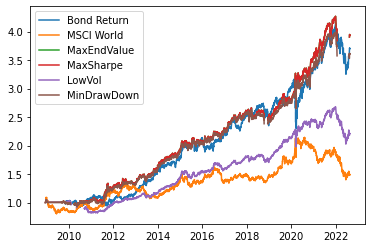

In [ ]:
plt.plot(BondReturn, label = "Bond Return")
plt.plot(MSCIReturn, label = "MSCI World")
plt.plot(MaxEndValueCum, label = "MaxEndValue")
plt.plot(MaxSharpeCum, label = "MaxSharpe")
plt.plot(LowVolCum, label = "LowVol")
plt.plot(MinDrawDownCum, label = "MinDrawDown")
plt.legend()
plt.show()